# **TẢI FRAMEWORK DETECTRON2**


In [ ]:
!pip install torch torchvision torchaudio
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-yc8v2rm3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-yc8v2rm3
  Resolved https://github.com/facebookresearch/detectron2.git to commit 536dc9d527074e3b15df5f6677ffe1f4e104a4ab
  Preparing metadata (setup.py) ... done


# **CÀI ĐẶT MỘT SỐ THƯ VIỆN PHÙ HỢP**

In [ ]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import các module chính
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
import cv2
import random
import os
import numpy as np
import json
import matplotlib.pyplot as plt

# **DÙNG API CỦA ROBOFLOW ĐỂ LOAD DỮ LIỆU**

In [ ]:
!curl -L "https://app.roboflow.com/ds/y7y25m3mfk?key=MYAPIKEY" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   3257      0 --:--:-- --:--:-- --:--:--  3264
100 30.8M  100 30.8M    0     0  19.1M      0  0:00:01  0:00:01 --:--:-- 44.4M
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
 extracting: test/0_jpg.rf.809fd3f8bbd948692405503064ee0386.jpg  
 extracting: test/10_jpg.rf.5387eca109780f9dfebb3290b62feabe.jpg  
 extracting: test/11_jpg.rf.46c6d5917de86c70a91cdeb3ab2610f3.jpg  
 extracting: test/11_jpg.rf.a5e9eb56eb4506c1b14113193a60b9c2.jpg  
 extracting: test/12_jpg.rf.3db77462dc37889cbcd1f58920324bf5.jpg  
 extracting: test/12_jpg.rf.41c3b8645b49fcbd9f85cf971fcd0997.jpg  
 extracting: test/13_jpg.rf.9958fcf2e7b6a57d38c1a31d88fe3d5d.jpg  
 extracting: test/14_jpg.rf.1dd84fe243adfc4f3e2e2ef51c5270fa.jpg  
 extracting: test/14_jpg.rf.88c

# **ĐĂNG KÝ DỮ LIỆU**

WARNING [05/05 02:43:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 02:43:28 d2.data.datasets.coco]: Loaded 936 images in COCO format from /content//train/_annotations.coco.json


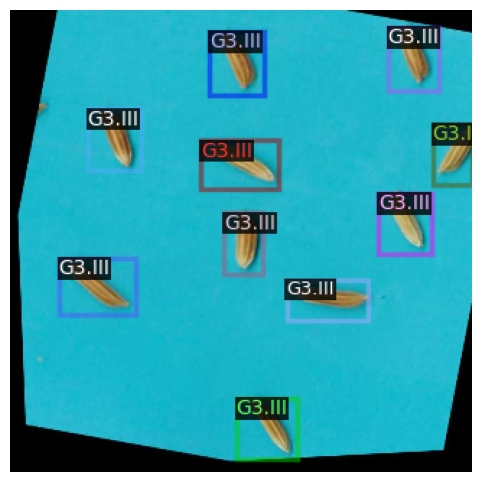

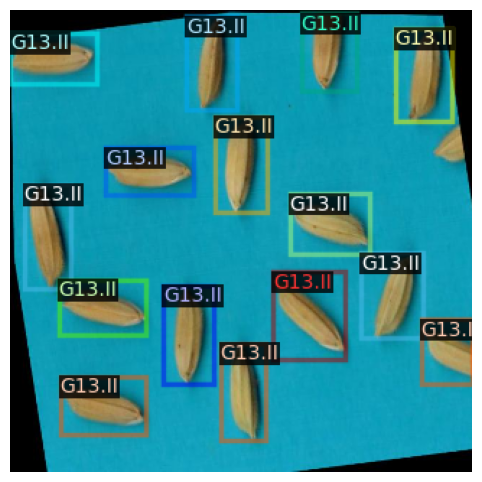

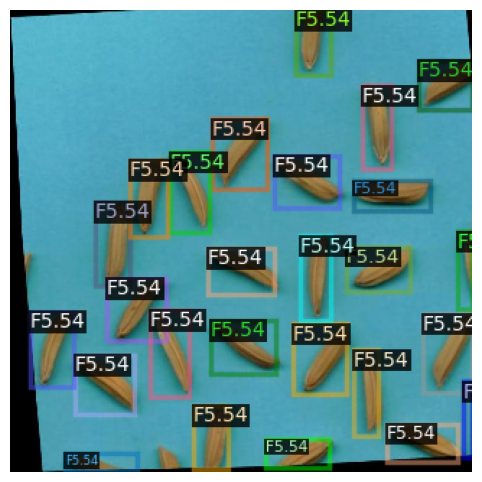

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt
import random
import os

dataset_path = "/content/"

for split in ["train", "valid", "test"]:
    img_dir = f"{dataset_path}/{split}/"
    ann_file = f"{dataset_path}/{split}/_annotations.coco.json"

    if os.path.exists(ann_file) and os.path.exists(img_dir):
        register_coco_instances(f"hat_lua_{split}", {}, ann_file, img_dir)

dataset_name = "hat_lua_train"

if dataset_name in DatasetCatalog.list():
    metadata = MetadataCatalog.get(dataset_name)
    dataset_dicts = DatasetCatalog.get(dataset_name)

    if len(dataset_dicts) != 0:
        for d in random.sample(dataset_dicts, min(3, len(dataset_dicts))):  # Hiển thị tối đa 3 ảnh
            img = cv2.imread(d["file_name"])

            if img is None:
                continue

            visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
            vis = visualizer.draw_dataset_dict(d)

            plt.figure(figsize=(8, 6))
            plt.imshow(vis.get_image())
            plt.axis("off")
            plt.show()

# **THIẾP LẬP CẤU HÌNH THAM SỐ HUẤN LUYỆN**

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os
import torch

cfg = get_cfg()
cfg.OUTPUT_DIR = "./Faster_R-CNN"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9
cfg.MODEL.DEVICE = "cuda"

cfg.DATASETS.TRAIN, cfg.DATASETS.TEST = ("hat_lua_train",), ("hat_lua_valid",)
cfg.DATALOADER.NUM_WORKERS = 4

cfg.INPUT.MIN_SIZE_TRAIN = cfg.INPUT.MIN_SIZE_TEST = 640
cfg.INPUT.MAX_SIZE_TRAIN = cfg.INPUT.MAX_SIZE_TEST = 640

cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.STEPS = (3000, 4000)
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.AMP.ENABLED = True
cfg.TEST.EVAL_PERIOD = 500
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16, 32, 64, 128, 256]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 2.0]]

class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        from detectron2.evaluation import COCOEvaluator
        return COCOEvaluator(dataset_name, cfg, True, output_folder or os.path.join(cfg.OUTPUT_DIR, "evaluation"))


# **HUẤN LUYỆN MÔ HÌNH**

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/05 02:43:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()
model_final_f6e8b1.pkl: 243MB [00:01, 217MB/s]                           
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[05/05 02:44:01 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-a

[05/05 02:44:32 d2.utils.events]:  eta: 1:56:23  iter: 19  total_loss: 3.34  loss_cls: 2.136  loss_box_reg: 0.04219  loss_rpn_cls: 0.7035  loss_rpn_loc: 0.4399    time: 1.4170  last_time: 1.5361  data_time: 0.1769  last_data_time: 0.2475   lr: 9.7405e-05  max_mem: 5467M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:45:11 d2.utils.events]:  eta: 1:58:49  iter: 39  total_loss: 1.203  loss_cls: 0.1919  loss_box_reg: 0.06855  loss_rpn_cls: 0.6527  loss_rpn_loc: 0.2943    time: 1.4657  last_time: 1.5277  data_time: 0.1818  last_data_time: 0.1676   lr: 0.0001973  max_mem: 5467M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:45:43 d2.utils.events]:  eta: 2:04:17  iter: 59  total_loss: 1.089  loss_cls: 0.1697  loss_box_reg: 0.1035  loss_rpn_cls: 0.5706  loss_rpn_loc: 0.2523    time: 1.5143  last_time: 1.6258  data_time: 0.1778  last_data_time: 0.2035   lr: 0.0002972  max_mem: 5467M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:46:15 d2.utils.events]:  eta: 2:07:26  iter: 79  total_loss: 2.195  loss_cls: 0.7027  loss_box_reg: 0.8167  loss_rpn_cls: 0.4504  loss_rpn_loc: 0.2191    time: 1.5406  last_time: 1.6096  data_time: 0.1732  last_data_time: 0.1765   lr: 0.00039711  max_mem: 5467M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:46:47 d2.utils.events]:  eta: 2:07:17  iter: 99  total_loss: 2.136  loss_cls: 0.7793  loss_box_reg: 0.8845  loss_rpn_cls: 0.2637  loss_rpn_loc: 0.2013    time: 1.5505  last_time: 1.6419  data_time: 0.1789  last_data_time: 0.2215   lr: 0.00049701  max_mem: 5467M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:47:19 d2.utils.events]:  eta: 2:06:47  iter: 119  total_loss: 1.91  loss_cls: 0.7529  loss_box_reg: 0.8122  loss_rpn_cls: 0.1367  loss_rpn_loc: 0.1967    time: 1.5543  last_time: 1.5678  data_time: 0.1805  last_data_time: 0.1948   lr: 0.00059691  max_mem: 5467M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:47:51 d2.utils.events]:  eta: 2:06:47  iter: 139  total_loss: 1.647  loss_cls: 0.7331  loss_box_reg: 0.6025  loss_rpn_cls: 0.1004  loss_rpn_loc: 0.2241    time: 1.5606  last_time: 1.5725  data_time: 0.1863  last_data_time: 0.1711   lr: 0.0006968  max_mem: 5467M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:48:22 d2.utils.events]:  eta: 2:06:21  iter: 159  total_loss: 1.414  loss_cls: 0.705  loss_box_reg: 0.4184  loss_rpn_cls: 0.08604  loss_rpn_loc: 0.1961    time: 1.5642  last_time: 1.5964  data_time: 0.1760  last_data_time: 0.1742   lr: 0.00079671  max_mem: 5467M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:48:54 d2.utils.events]:  eta: 2:05:58  iter: 179  total_loss: 1.392  loss_cls: 0.7148  loss_box_reg: 0.3986  loss_rpn_cls: 0.09126  loss_rpn_loc: 0.1774    time: 1.5679  last_time: 1.5713  data_time: 0.1784  last_data_time: 0.1666   lr: 0.0008966  max_mem: 5467M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:49:26 d2.utils.events]:  eta: 2:05:44  iter: 199  total_loss: 1.266  loss_cls: 0.6822  loss_box_reg: 0.349  loss_rpn_cls: 0.07505  loss_rpn_loc: 0.1574    time: 1.5713  last_time: 1.6629  data_time: 0.1724  last_data_time: 0.2078   lr: 0.0009965  max_mem: 5475M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:49:58 d2.utils.events]:  eta: 2:05:25  iter: 219  total_loss: 1.24  loss_cls: 0.6717  loss_box_reg: 0.3355  loss_rpn_cls: 0.07209  loss_rpn_loc: 0.1532    time: 1.5744  last_time: 1.5963  data_time: 0.1845  last_data_time: 0.1903   lr: 0.0010964  max_mem: 5478M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:50:31 d2.utils.events]:  eta: 2:05:05  iter: 239  total_loss: 1.172  loss_cls: 0.6459  loss_box_reg: 0.3179  loss_rpn_cls: 0.05758  loss_rpn_loc: 0.1382    time: 1.5769  last_time: 1.5849  data_time: 0.1629  last_data_time: 0.1335   lr: 0.0011963  max_mem: 5491M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:51:03 d2.utils.events]:  eta: 2:04:38  iter: 259  total_loss: 1.145  loss_cls: 0.6257  loss_box_reg: 0.3152  loss_rpn_cls: 0.05725  loss_rpn_loc: 0.1516    time: 1.5795  last_time: 1.5636  data_time: 0.1710  last_data_time: 0.1280   lr: 0.0012962  max_mem: 5495M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:51:35 d2.utils.events]:  eta: 2:04:28  iter: 279  total_loss: 1.116  loss_cls: 0.6074  loss_box_reg: 0.2981  loss_rpn_cls: 0.06139  loss_rpn_loc: 0.1408    time: 1.5822  last_time: 1.6168  data_time: 0.1792  last_data_time: 0.1774   lr: 0.0013961  max_mem: 5509M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:52:08 d2.utils.events]:  eta: 2:04:11  iter: 299  total_loss: 1.101  loss_cls: 0.5652  loss_box_reg: 0.3163  loss_rpn_cls: 0.05475  loss_rpn_loc: 0.1411    time: 1.5856  last_time: 1.6090  data_time: 0.1886  last_data_time: 0.1636   lr: 0.001496  max_mem: 5519M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:52:40 d2.utils.events]:  eta: 2:03:42  iter: 319  total_loss: 1.051  loss_cls: 0.5399  loss_box_reg: 0.3184  loss_rpn_cls: 0.05355  loss_rpn_loc: 0.1416    time: 1.5871  last_time: 1.5823  data_time: 0.1637  last_data_time: 0.1294   lr: 0.0015959  max_mem: 5519M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:53:12 d2.utils.events]:  eta: 2:03:22  iter: 339  total_loss: 0.9772  loss_cls: 0.5051  loss_box_reg: 0.3029  loss_rpn_cls: 0.046  loss_rpn_loc: 0.1274    time: 1.5892  last_time: 1.5640  data_time: 0.1824  last_data_time: 0.1549   lr: 0.0016958  max_mem: 5522M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:53:45 d2.utils.events]:  eta: 2:02:51  iter: 359  total_loss: 0.9734  loss_cls: 0.5071  loss_box_reg: 0.2989  loss_rpn_cls: 0.04336  loss_rpn_loc: 0.132    time: 1.5909  last_time: 1.6163  data_time: 0.1757  last_data_time: 0.1765   lr: 0.0017957  max_mem: 5522M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:54:17 d2.utils.events]:  eta: 2:02:29  iter: 379  total_loss: 1.017  loss_cls: 0.5229  loss_box_reg: 0.2968  loss_rpn_cls: 0.04962  loss_rpn_loc: 0.1404    time: 1.5925  last_time: 1.5759  data_time: 0.1787  last_data_time: 0.1577   lr: 0.0018956  max_mem: 5528M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:54:50 d2.utils.events]:  eta: 2:02:02  iter: 399  total_loss: 0.9681  loss_cls: 0.4638  loss_box_reg: 0.3129  loss_rpn_cls: 0.04816  loss_rpn_loc: 0.1308    time: 1.5940  last_time: 1.5959  data_time: 0.1810  last_data_time: 0.1546   lr: 0.0019955  max_mem: 5529M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:55:22 d2.utils.events]:  eta: 2:01:35  iter: 419  total_loss: 0.931  loss_cls: 0.4643  loss_box_reg: 0.3112  loss_rpn_cls: 0.04662  loss_rpn_loc: 0.1269    time: 1.5954  last_time: 1.5773  data_time: 0.1789  last_data_time: 0.1539   lr: 0.0020954  max_mem: 5531M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:55:55 d2.utils.events]:  eta: 2:01:10  iter: 439  total_loss: 0.8706  loss_cls: 0.4243  loss_box_reg: 0.2897  loss_rpn_cls: 0.04066  loss_rpn_loc: 0.1178    time: 1.5967  last_time: 1.5976  data_time: 0.1805  last_data_time: 0.1565   lr: 0.0021953  max_mem: 5531M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:56:27 d2.utils.events]:  eta: 2:00:37  iter: 459  total_loss: 0.8947  loss_cls: 0.4192  loss_box_reg: 0.3017  loss_rpn_cls: 0.04027  loss_rpn_loc: 0.1204    time: 1.5971  last_time: 1.6209  data_time: 0.1707  last_data_time: 0.1533   lr: 0.0022952  max_mem: 5531M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:56:59 d2.utils.events]:  eta: 2:00:07  iter: 479  total_loss: 0.846  loss_cls: 0.3939  loss_box_reg: 0.2881  loss_rpn_cls: 0.03756  loss_rpn_loc: 0.1237    time: 1.5981  last_time: 1.7819  data_time: 0.1704  last_data_time: 0.2978   lr: 0.0023951  max_mem: 5531M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

WARNING [05/05 02:57:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 02:57:32 d2.data.datasets.coco]: Loaded 104 images in COCO format from /content//valid/_annotations.coco.json
[05/05 02:57:32 d2.data.build]: Distribution of instances among all 9 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| rice-seed  | 0            |   ANP3.2   | 117          |   F5.54    | 161          |
|   F5.62    | 171          |   G13.II   | 251          |  G17.III   | 154          |
|   G18.1    | 216          |   G3.III   | 153          |   G7.III   | 122          |
|            |              |            |              |            |              |
|   total    | 1345         |            |              |            |              |
[05/05 02:57:32 d2.data.dataset_mapper]: [DatasetMapper] Augm

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loo

[05/05 02:58:04 d2.utils.events]:  eta: 1:59:04  iter: 519  total_loss: 0.834  loss_cls: 0.3807  loss_box_reg: 0.2882  loss_rpn_cls: 0.03973  loss_rpn_loc: 0.1203    time: 1.5998  last_time: 1.5537  data_time: 0.1794  last_data_time: 0.1317   lr: 0.0025  max_mem: 5531M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:58:37 d2.utils.events]:  eta: 1:58:33  iter: 539  total_loss: 0.8746  loss_cls: 0.4273  loss_box_reg: 0.2971  loss_rpn_cls: 0.03807  loss_rpn_loc: 0.1194    time: 1.6008  last_time: 1.7729  data_time: 0.1824  last_data_time: 0.2895   lr: 0.0025  max_mem: 5531M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:59:09 d2.utils.events]:  eta: 1:58:00  iter: 559  total_loss: 0.853  loss_cls: 0.4092  loss_box_reg: 0.2872  loss_rpn_cls: 0.03394  loss_rpn_loc: 0.1173    time: 1.6011  last_time: 1.5850  data_time: 0.1765  last_data_time: 0.1725   lr: 0.0025  max_mem: 5531M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 02:59:41 d2.utils.events]:  eta: 1:57:27  iter: 579  total_loss: 0.7655  loss_cls: 0.3527  loss_box_reg: 0.2716  loss_rpn_cls: 0.03184  loss_rpn_loc: 0.1103    time: 1.6012  last_time: 1.5996  data_time: 0.1697  last_data_time: 0.1815   lr: 0.0025  max_mem: 5531M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:00:13 d2.utils.events]:  eta: 1:56:56  iter: 599  total_loss: 0.76  loss_cls: 0.3494  loss_box_reg: 0.2782  loss_rpn_cls: 0.03392  loss_rpn_loc: 0.1069    time: 1.6018  last_time: 1.7292  data_time: 0.1832  last_data_time: 0.2566   lr: 0.0025  max_mem: 5531M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:00:46 d2.utils.events]:  eta: 1:56:25  iter: 619  total_loss: 0.7717  loss_cls: 0.3744  loss_box_reg: 0.2757  loss_rpn_cls: 0.03002  loss_rpn_loc: 0.1017    time: 1.6021  last_time: 1.5796  data_time: 0.1856  last_data_time: 0.1677   lr: 0.0025  max_mem: 5531M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:01:18 d2.utils.events]:  eta: 1:55:52  iter: 639  total_loss: 0.7373  loss_cls: 0.3255  loss_box_reg: 0.2798  loss_rpn_cls: 0.03019  loss_rpn_loc: 0.1043    time: 1.6024  last_time: 1.5828  data_time: 0.1753  last_data_time: 0.1503   lr: 0.0025  max_mem: 5531M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:01:50 d2.utils.events]:  eta: 1:55:20  iter: 659  total_loss: 0.7232  loss_cls: 0.3195  loss_box_reg: 0.2734  loss_rpn_cls: 0.03069  loss_rpn_loc: 0.1059    time: 1.6024  last_time: 1.5884  data_time: 0.1706  last_data_time: 0.1611   lr: 0.0025  max_mem: 5531M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:02:22 d2.utils.events]:  eta: 1:54:48  iter: 679  total_loss: 0.7159  loss_cls: 0.3062  loss_box_reg: 0.2729  loss_rpn_cls: 0.03194  loss_rpn_loc: 0.1031    time: 1.6025  last_time: 1.5750  data_time: 0.1775  last_data_time: 0.1641   lr: 0.0025  max_mem: 5531M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:02:54 d2.utils.events]:  eta: 1:54:16  iter: 699  total_loss: 0.6817  loss_cls: 0.2891  loss_box_reg: 0.2784  loss_rpn_cls: 0.02789  loss_rpn_loc: 0.1018    time: 1.6030  last_time: 1.7053  data_time: 0.1876  last_data_time: 0.2656   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:03:27 d2.utils.events]:  eta: 1:53:44  iter: 719  total_loss: 0.7381  loss_cls: 0.3163  loss_box_reg: 0.2734  loss_rpn_cls: 0.02859  loss_rpn_loc: 0.1074    time: 1.6031  last_time: 1.5760  data_time: 0.1744  last_data_time: 0.1582   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:03:59 d2.utils.events]:  eta: 1:53:12  iter: 739  total_loss: 0.6671  loss_cls: 0.2793  loss_box_reg: 0.2579  loss_rpn_cls: 0.03183  loss_rpn_loc: 0.1038    time: 1.6033  last_time: 1.6159  data_time: 0.1761  last_data_time: 0.1783   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:04:31 d2.utils.events]:  eta: 1:52:40  iter: 759  total_loss: 0.7189  loss_cls: 0.303  loss_box_reg: 0.2749  loss_rpn_cls: 0.02848  loss_rpn_loc: 0.1034    time: 1.6036  last_time: 1.8046  data_time: 0.1869  last_data_time: 0.3097   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:05:03 d2.utils.events]:  eta: 1:52:08  iter: 779  total_loss: 0.6643  loss_cls: 0.2823  loss_box_reg: 0.255  loss_rpn_cls: 0.02759  loss_rpn_loc: 0.09366    time: 1.6034  last_time: 1.5541  data_time: 0.1820  last_data_time: 0.1667   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:05:35 d2.utils.events]:  eta: 1:51:34  iter: 799  total_loss: 0.6573  loss_cls: 0.2527  loss_box_reg: 0.2606  loss_rpn_cls: 0.02611  loss_rpn_loc: 0.09815    time: 1.6034  last_time: 1.6041  data_time: 0.1728  last_data_time: 0.1747   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:06:07 d2.utils.events]:  eta: 1:50:59  iter: 819  total_loss: 0.648  loss_cls: 0.2634  loss_box_reg: 0.2699  loss_rpn_cls: 0.02618  loss_rpn_loc: 0.09782    time: 1.6031  last_time: 1.5642  data_time: 0.1709  last_data_time: 0.1723   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:06:39 d2.utils.events]:  eta: 1:50:26  iter: 839  total_loss: 0.6351  loss_cls: 0.2388  loss_box_reg: 0.2573  loss_rpn_cls: 0.0264  loss_rpn_loc: 0.1035    time: 1.6032  last_time: 1.5583  data_time: 0.1812  last_data_time: 0.1308   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:07:11 d2.utils.events]:  eta: 1:49:54  iter: 859  total_loss: 0.6494  loss_cls: 0.2526  loss_box_reg: 0.2674  loss_rpn_cls: 0.02867  loss_rpn_loc: 0.1043    time: 1.6030  last_time: 1.6443  data_time: 0.1712  last_data_time: 0.1925   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:07:43 d2.utils.events]:  eta: 1:49:22  iter: 879  total_loss: 0.6324  loss_cls: 0.2359  loss_box_reg: 0.2626  loss_rpn_cls: 0.02545  loss_rpn_loc: 0.1011    time: 1.6028  last_time: 1.5696  data_time: 0.1680  last_data_time: 0.1640   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:08:15 d2.utils.events]:  eta: 1:48:49  iter: 899  total_loss: 0.6123  loss_cls: 0.2392  loss_box_reg: 0.2457  loss_rpn_cls: 0.02728  loss_rpn_loc: 0.09491    time: 1.6030  last_time: 1.5782  data_time: 0.1819  last_data_time: 0.1614   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:08:47 d2.utils.events]:  eta: 1:48:16  iter: 919  total_loss: 0.6158  loss_cls: 0.2535  loss_box_reg: 0.2425  loss_rpn_cls: 0.02231  loss_rpn_loc: 0.09716    time: 1.6027  last_time: 1.5706  data_time: 0.1686  last_data_time: 0.1269   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:09:19 d2.utils.events]:  eta: 1:47:45  iter: 939  total_loss: 0.5717  loss_cls: 0.2336  loss_box_reg: 0.2421  loss_rpn_cls: 0.02191  loss_rpn_loc: 0.0915    time: 1.6031  last_time: 1.5462  data_time: 0.1949  last_data_time: 0.1524   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:09:51 d2.utils.events]:  eta: 1:47:12  iter: 959  total_loss: 0.6165  loss_cls: 0.2342  loss_box_reg: 0.2448  loss_rpn_cls: 0.02718  loss_rpn_loc: 0.09499    time: 1.6032  last_time: 1.5871  data_time: 0.1793  last_data_time: 0.1589   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:10:24 d2.utils.events]:  eta: 1:46:39  iter: 979  total_loss: 0.5737  loss_cls: 0.2024  loss_box_reg: 0.237  loss_rpn_cls: 0.02273  loss_rpn_loc: 0.09287    time: 1.6031  last_time: 1.5952  data_time: 0.1852  last_data_time: 0.1677   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

WARNING [05/05 03:11:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 03:11:00 d2.data.datasets.coco]: Loaded 104 images in COCO format from /content//valid/_annotations.coco.json
[05/05 03:11:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[05/05 03:11:00 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 03:11:00 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[05/05 03:11:00 d2.data.common]: Serialized dataset takes 0.06 MiB
WARNING [05/05 03:11:00 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[05/05 03:11:00 d2.utils.events]:  eta: 1:46:07  iter: 999  total_loss: 0.5872  loss_cls: 0.2159  loss_box_reg: 0.2445  loss_rpn_

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loo

[05/05 03:11:33 d2.utils.events]:  eta: 1:45:37  iter: 1019  total_loss: 0.5644  loss_cls: 0.2101  loss_box_reg: 0.2433  loss_rpn_cls: 0.02158  loss_rpn_loc: 0.0871    time: 1.6033  last_time: 1.6034  data_time: 0.1839  last_data_time: 0.1739   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:12:05 d2.utils.events]:  eta: 1:45:07  iter: 1039  total_loss: 0.539  loss_cls: 0.1914  loss_box_reg: 0.2357  loss_rpn_cls: 0.02309  loss_rpn_loc: 0.09451    time: 1.6033  last_time: 1.6301  data_time: 0.1770  last_data_time: 0.2149   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:12:37 d2.utils.events]:  eta: 1:44:34  iter: 1059  total_loss: 0.5367  loss_cls: 0.1862  loss_box_reg: 0.2331  loss_rpn_cls: 0.02192  loss_rpn_loc: 0.08858    time: 1.6029  last_time: 1.5270  data_time: 0.1711  last_data_time: 0.1276   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:13:09 d2.utils.events]:  eta: 1:44:00  iter: 1079  total_loss: 0.553  loss_cls: 0.1798  loss_box_reg: 0.2417  loss_rpn_cls: 0.02168  loss_rpn_loc: 0.09193    time: 1.6030  last_time: 1.5395  data_time: 0.1787  last_data_time: 0.1283   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:13:41 d2.utils.events]:  eta: 1:43:28  iter: 1099  total_loss: 0.5355  loss_cls: 0.1733  loss_box_reg: 0.2449  loss_rpn_cls: 0.02143  loss_rpn_loc: 0.09273    time: 1.6028  last_time: 1.5981  data_time: 0.1784  last_data_time: 0.1560   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:14:13 d2.utils.events]:  eta: 1:42:57  iter: 1119  total_loss: 0.5374  loss_cls: 0.1827  loss_box_reg: 0.2306  loss_rpn_cls: 0.02137  loss_rpn_loc: 0.08761    time: 1.6027  last_time: 1.5597  data_time: 0.1812  last_data_time: 0.1666   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:14:45 d2.utils.events]:  eta: 1:42:24  iter: 1139  total_loss: 0.5122  loss_cls: 0.1763  loss_box_reg: 0.2273  loss_rpn_cls: 0.02008  loss_rpn_loc: 0.08632    time: 1.6026  last_time: 1.5887  data_time: 0.1738  last_data_time: 0.1698   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:15:16 d2.utils.events]:  eta: 1:41:52  iter: 1159  total_loss: 0.5232  loss_cls: 0.1944  loss_box_reg: 0.2287  loss_rpn_cls: 0.02027  loss_rpn_loc: 0.08648    time: 1.6024  last_time: 1.5562  data_time: 0.1741  last_data_time: 0.1657   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:15:49 d2.utils.events]:  eta: 1:41:20  iter: 1179  total_loss: 0.5416  loss_cls: 0.1913  loss_box_reg: 0.2315  loss_rpn_cls: 0.01894  loss_rpn_loc: 0.08792    time: 1.6024  last_time: 1.5950  data_time: 0.1809  last_data_time: 0.1749   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:16:21 d2.utils.events]:  eta: 1:40:48  iter: 1199  total_loss: 0.4924  loss_cls: 0.1574  loss_box_reg: 0.2323  loss_rpn_cls: 0.02002  loss_rpn_loc: 0.08461    time: 1.6024  last_time: 1.7223  data_time: 0.1776  last_data_time: 0.2670   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:16:53 d2.utils.events]:  eta: 1:40:16  iter: 1219  total_loss: 0.5073  loss_cls: 0.1647  loss_box_reg: 0.2322  loss_rpn_cls: 0.01852  loss_rpn_loc: 0.08606    time: 1.6023  last_time: 1.5596  data_time: 0.1767  last_data_time: 0.1710   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:17:25 d2.utils.events]:  eta: 1:39:44  iter: 1239  total_loss: 0.4732  loss_cls: 0.1492  loss_box_reg: 0.2205  loss_rpn_cls: 0.0173  loss_rpn_loc: 0.08233    time: 1.6024  last_time: 1.5593  data_time: 0.1885  last_data_time: 0.1379   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:17:57 d2.utils.events]:  eta: 1:39:12  iter: 1259  total_loss: 0.5288  loss_cls: 0.1914  loss_box_reg: 0.2206  loss_rpn_cls: 0.01842  loss_rpn_loc: 0.08654    time: 1.6024  last_time: 1.5562  data_time: 0.1788  last_data_time: 0.1578   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:18:29 d2.utils.events]:  eta: 1:38:37  iter: 1279  total_loss: 0.4864  loss_cls: 0.1576  loss_box_reg: 0.2133  loss_rpn_cls: 0.01823  loss_rpn_loc: 0.08195    time: 1.6024  last_time: 1.5157  data_time: 0.1936  last_data_time: 0.1205   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:19:01 d2.utils.events]:  eta: 1:38:04  iter: 1299  total_loss: 0.5105  loss_cls: 0.1767  loss_box_reg: 0.2174  loss_rpn_cls: 0.02015  loss_rpn_loc: 0.08499    time: 1.6024  last_time: 1.7175  data_time: 0.1832  last_data_time: 0.2429   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:19:33 d2.utils.events]:  eta: 1:37:31  iter: 1319  total_loss: 0.4812  loss_cls: 0.1534  loss_box_reg: 0.2236  loss_rpn_cls: 0.01678  loss_rpn_loc: 0.08228    time: 1.6023  last_time: 1.5903  data_time: 0.1770  last_data_time: 0.1931   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:20:05 d2.utils.events]:  eta: 1:36:56  iter: 1339  total_loss: 0.4461  loss_cls: 0.1367  loss_box_reg: 0.212  loss_rpn_cls: 0.01624  loss_rpn_loc: 0.0805    time: 1.6022  last_time: 1.5617  data_time: 0.1853  last_data_time: 0.1691   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:20:37 d2.utils.events]:  eta: 1:36:22  iter: 1359  total_loss: 0.4565  loss_cls: 0.1463  loss_box_reg: 0.2108  loss_rpn_cls: 0.01752  loss_rpn_loc: 0.08387    time: 1.6020  last_time: 1.6007  data_time: 0.1782  last_data_time: 0.1970   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:21:09 d2.utils.events]:  eta: 1:35:49  iter: 1379  total_loss: 0.4682  loss_cls: 0.1491  loss_box_reg: 0.2156  loss_rpn_cls: 0.01757  loss_rpn_loc: 0.08777    time: 1.6020  last_time: 1.5923  data_time: 0.1854  last_data_time: 0.1686   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:21:40 d2.utils.events]:  eta: 1:35:16  iter: 1399  total_loss: 0.4809  loss_cls: 0.1607  loss_box_reg: 0.2047  loss_rpn_cls: 0.01895  loss_rpn_loc: 0.08214    time: 1.6018  last_time: 1.6995  data_time: 0.1746  last_data_time: 0.2029   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:22:12 d2.utils.events]:  eta: 1:34:41  iter: 1419  total_loss: 0.4554  loss_cls: 0.1499  loss_box_reg: 0.2149  loss_rpn_cls: 0.01661  loss_rpn_loc: 0.07986    time: 1.6017  last_time: 1.5786  data_time: 0.1790  last_data_time: 0.1712   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:22:44 d2.utils.events]:  eta: 1:34:07  iter: 1439  total_loss: 0.464  loss_cls: 0.1488  loss_box_reg: 0.2128  loss_rpn_cls: 0.01531  loss_rpn_loc: 0.07908    time: 1.6016  last_time: 1.5750  data_time: 0.1892  last_data_time: 0.2084   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:23:16 d2.utils.events]:  eta: 1:33:35  iter: 1459  total_loss: 0.4714  loss_cls: 0.1636  loss_box_reg: 0.218  loss_rpn_cls: 0.01679  loss_rpn_loc: 0.07936    time: 1.6015  last_time: 1.5821  data_time: 0.1754  last_data_time: 0.1672   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:23:48 d2.utils.events]:  eta: 1:33:02  iter: 1479  total_loss: 0.4444  loss_cls: 0.1553  loss_box_reg: 0.1992  loss_rpn_cls: 0.01548  loss_rpn_loc: 0.08165    time: 1.6015  last_time: 1.5539  data_time: 0.1821  last_data_time: 0.1546   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

WARNING [05/05 03:24:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 03:24:20 d2.data.datasets.coco]: Loaded 104 images in COCO format from /content//valid/_annotations.coco.json
[05/05 03:24:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[05/05 03:24:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 03:24:20 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[05/05 03:24:20 d2.data.common]: Serialized dataset takes 0.06 MiB
WARNING [05/05 03:24:20 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[05/05 03:24:20 d2.utils.events]:  eta: 1:32:27  iter: 1499  total_loss: 0.4411  loss_cls: 0.1397  loss_box_reg: 0.2107  loss_rpn

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loo

[05/05 03:24:52 d2.utils.events]:  eta: 1:31:53  iter: 1519  total_loss: 0.4287  loss_cls: 0.1321  loss_box_reg: 0.1998  loss_rpn_cls: 0.01671  loss_rpn_loc: 0.07876    time: 1.6012  last_time: 1.5569  data_time: 0.1763  last_data_time: 0.1412   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:25:24 d2.utils.events]:  eta: 1:31:20  iter: 1539  total_loss: 0.4398  loss_cls: 0.1351  loss_box_reg: 0.1988  loss_rpn_cls: 0.0177  loss_rpn_loc: 0.08178    time: 1.6013  last_time: 1.5682  data_time: 0.1815  last_data_time: 0.1603   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:25:56 d2.utils.events]:  eta: 1:30:47  iter: 1559  total_loss: 0.464  loss_cls: 0.1709  loss_box_reg: 0.2025  loss_rpn_cls: 0.01604  loss_rpn_loc: 0.08065    time: 1.6011  last_time: 1.6055  data_time: 0.1750  last_data_time: 0.1784   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:26:28 d2.utils.events]:  eta: 1:30:15  iter: 1579  total_loss: 0.4389  loss_cls: 0.1339  loss_box_reg: 0.2018  loss_rpn_cls: 0.01827  loss_rpn_loc: 0.0837    time: 1.6010  last_time: 1.6277  data_time: 0.1747  last_data_time: 0.1792   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:27:00 d2.utils.events]:  eta: 1:29:43  iter: 1599  total_loss: 0.4099  loss_cls: 0.12  loss_box_reg: 0.1941  loss_rpn_cls: 0.01729  loss_rpn_loc: 0.07887    time: 1.6010  last_time: 1.5957  data_time: 0.1801  last_data_time: 0.1917   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:27:31 d2.utils.events]:  eta: 1:29:09  iter: 1619  total_loss: 0.419  loss_cls: 0.1294  loss_box_reg: 0.1927  loss_rpn_cls: 0.01524  loss_rpn_loc: 0.07732    time: 1.6008  last_time: 1.5630  data_time: 0.1728  last_data_time: 0.1618   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:28:03 d2.utils.events]:  eta: 1:28:37  iter: 1639  total_loss: 0.3861  loss_cls: 0.1148  loss_box_reg: 0.1867  loss_rpn_cls: 0.01469  loss_rpn_loc: 0.07676    time: 1.6009  last_time: 1.5712  data_time: 0.1921  last_data_time: 0.1350   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:28:35 d2.utils.events]:  eta: 1:28:03  iter: 1659  total_loss: 0.382  loss_cls: 0.1081  loss_box_reg: 0.1794  loss_rpn_cls: 0.01403  loss_rpn_loc: 0.07394    time: 1.6007  last_time: 1.6131  data_time: 0.1679  last_data_time: 0.1738   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:29:07 d2.utils.events]:  eta: 1:27:29  iter: 1679  total_loss: 0.3904  loss_cls: 0.1089  loss_box_reg: 0.1839  loss_rpn_cls: 0.01531  loss_rpn_loc: 0.07665    time: 1.6006  last_time: 1.5617  data_time: 0.1839  last_data_time: 0.1493   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:29:39 d2.utils.events]:  eta: 1:26:55  iter: 1699  total_loss: 0.3888  loss_cls: 0.1106  loss_box_reg: 0.1884  loss_rpn_cls: 0.01478  loss_rpn_loc: 0.07382    time: 1.6005  last_time: 1.5541  data_time: 0.1825  last_data_time: 0.1638   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:30:11 d2.utils.events]:  eta: 1:26:22  iter: 1719  total_loss: 0.403  loss_cls: 0.115  loss_box_reg: 0.1988  loss_rpn_cls: 0.0135  loss_rpn_loc: 0.0766    time: 1.6005  last_time: 1.5829  data_time: 0.1767  last_data_time: 0.1633   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:30:42 d2.utils.events]:  eta: 1:25:49  iter: 1739  total_loss: 0.3888  loss_cls: 0.1075  loss_box_reg: 0.1886  loss_rpn_cls: 0.01403  loss_rpn_loc: 0.07643    time: 1.6002  last_time: 1.5622  data_time: 0.1729  last_data_time: 0.1648   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:31:14 d2.utils.events]:  eta: 1:25:17  iter: 1759  total_loss: 0.3949  loss_cls: 0.1052  loss_box_reg: 0.1963  loss_rpn_cls: 0.01572  loss_rpn_loc: 0.07357    time: 1.6000  last_time: 1.5952  data_time: 0.1758  last_data_time: 0.1386   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:31:46 d2.utils.events]:  eta: 1:24:45  iter: 1779  total_loss: 0.3794  loss_cls: 0.1062  loss_box_reg: 0.1849  loss_rpn_cls: 0.01405  loss_rpn_loc: 0.07339    time: 1.6000  last_time: 1.5546  data_time: 0.1788  last_data_time: 0.1610   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:32:18 d2.utils.events]:  eta: 1:24:13  iter: 1799  total_loss: 0.3727  loss_cls: 0.1068  loss_box_reg: 0.1768  loss_rpn_cls: 0.01499  loss_rpn_loc: 0.07231    time: 1.5999  last_time: 1.5948  data_time: 0.1874  last_data_time: 0.1980   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:32:49 d2.utils.events]:  eta: 1:23:40  iter: 1819  total_loss: 0.3545  loss_cls: 0.1016  loss_box_reg: 0.1719  loss_rpn_cls: 0.01377  loss_rpn_loc: 0.06939    time: 1.5996  last_time: 1.5642  data_time: 0.1662  last_data_time: 0.1678   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:33:21 d2.utils.events]:  eta: 1:23:08  iter: 1839  total_loss: 0.3665  loss_cls: 0.09843  loss_box_reg: 0.1807  loss_rpn_cls: 0.01233  loss_rpn_loc: 0.07365    time: 1.5995  last_time: 1.5795  data_time: 0.1818  last_data_time: 0.1840   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:33:53 d2.utils.events]:  eta: 1:22:36  iter: 1859  total_loss: 0.3519  loss_cls: 0.09253  loss_box_reg: 0.1703  loss_rpn_cls: 0.01568  loss_rpn_loc: 0.0728    time: 1.5993  last_time: 1.6176  data_time: 0.1794  last_data_time: 0.1736   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:34:25 d2.utils.events]:  eta: 1:22:02  iter: 1879  total_loss: 0.348  loss_cls: 0.09197  loss_box_reg: 0.1727  loss_rpn_cls: 0.0137  loss_rpn_loc: 0.0734    time: 1.5991  last_time: 1.5616  data_time: 0.1794  last_data_time: 0.1670   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:34:56 d2.utils.events]:  eta: 1:21:31  iter: 1899  total_loss: 0.361  loss_cls: 0.09665  loss_box_reg: 0.1759  loss_rpn_cls: 0.01255  loss_rpn_loc: 0.07082    time: 1.5990  last_time: 1.6672  data_time: 0.1756  last_data_time: 0.2475   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:35:28 d2.utils.events]:  eta: 1:20:59  iter: 1919  total_loss: 0.3414  loss_cls: 0.08734  loss_box_reg: 0.1697  loss_rpn_cls: 0.01267  loss_rpn_loc: 0.06791    time: 1.5988  last_time: 1.5555  data_time: 0.1785  last_data_time: 0.1646   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:36:00 d2.utils.events]:  eta: 1:20:25  iter: 1939  total_loss: 0.3315  loss_cls: 0.08761  loss_box_reg: 0.1626  loss_rpn_cls: 0.01278  loss_rpn_loc: 0.06688    time: 1.5987  last_time: 1.5975  data_time: 0.1753  last_data_time: 0.1847   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:36:31 d2.utils.events]:  eta: 1:19:52  iter: 1959  total_loss: 0.3362  loss_cls: 0.08576  loss_box_reg: 0.1656  loss_rpn_cls: 0.01153  loss_rpn_loc: 0.06859    time: 1.5985  last_time: 1.5759  data_time: 0.1719  last_data_time: 0.1801   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:37:03 d2.utils.events]:  eta: 1:19:19  iter: 1979  total_loss: 0.357  loss_cls: 0.09298  loss_box_reg: 0.1751  loss_rpn_cls: 0.01299  loss_rpn_loc: 0.07088    time: 1.5985  last_time: 1.5597  data_time: 0.1882  last_data_time: 0.1754   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

WARNING [05/05 03:37:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 03:37:43 d2.data.datasets.coco]: Loaded 104 images in COCO format from /content//valid/_annotations.coco.json
[05/05 03:37:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[05/05 03:37:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 03:37:43 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[05/05 03:37:43 d2.data.common]: Serialized dataset takes 0.06 MiB
WARNING [05/05 03:37:43 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[05/05 03:37:43 d2.utils.events]:  eta: 1:18:48  iter: 1999  total_loss: 0.3658  loss_cls: 0.09296  loss_box_reg: 0.1837  loss_rp

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loo

[05/05 03:38:15 d2.utils.events]:  eta: 1:18:16  iter: 2019  total_loss: 0.3376  loss_cls: 0.08549  loss_box_reg: 0.1714  loss_rpn_cls: 0.0133  loss_rpn_loc: 0.07032    time: 1.5986  last_time: 1.5933  data_time: 0.1833  last_data_time: 0.1962   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:38:47 d2.utils.events]:  eta: 1:17:44  iter: 2039  total_loss: 0.3276  loss_cls: 0.08647  loss_box_reg: 0.1597  loss_rpn_cls: 0.01192  loss_rpn_loc: 0.06704    time: 1.5984  last_time: 1.5756  data_time: 0.1743  last_data_time: 0.1671   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:39:19 d2.utils.events]:  eta: 1:17:12  iter: 2059  total_loss: 0.3375  loss_cls: 0.08409  loss_box_reg: 0.1649  loss_rpn_cls: 0.01202  loss_rpn_loc: 0.06901    time: 1.5984  last_time: 1.5736  data_time: 0.1897  last_data_time: 0.1580   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:39:51 d2.utils.events]:  eta: 1:16:40  iter: 2079  total_loss: 0.3234  loss_cls: 0.08251  loss_box_reg: 0.1576  loss_rpn_cls: 0.01292  loss_rpn_loc: 0.07084    time: 1.5983  last_time: 1.6992  data_time: 0.1743  last_data_time: 0.2775   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:40:22 d2.utils.events]:  eta: 1:16:08  iter: 2099  total_loss: 0.3177  loss_cls: 0.08396  loss_box_reg: 0.1537  loss_rpn_cls: 0.01361  loss_rpn_loc: 0.06788    time: 1.5982  last_time: 1.5850  data_time: 0.1824  last_data_time: 0.1729   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:40:54 d2.utils.events]:  eta: 1:15:36  iter: 2119  total_loss: 0.3227  loss_cls: 0.08589  loss_box_reg: 0.1582  loss_rpn_cls: 0.01184  loss_rpn_loc: 0.06839    time: 1.5982  last_time: 1.5643  data_time: 0.1889  last_data_time: 0.1597   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:41:26 d2.utils.events]:  eta: 1:15:04  iter: 2139  total_loss: 0.3352  loss_cls: 0.08522  loss_box_reg: 0.167  loss_rpn_cls: 0.01248  loss_rpn_loc: 0.06699    time: 1.5980  last_time: 1.5694  data_time: 0.1791  last_data_time: 0.1595   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:41:58 d2.utils.events]:  eta: 1:14:33  iter: 2159  total_loss: 0.3269  loss_cls: 0.08476  loss_box_reg: 0.161  loss_rpn_cls: 0.01149  loss_rpn_loc: 0.06769    time: 1.5980  last_time: 1.5587  data_time: 0.1851  last_data_time: 0.1536   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:42:30 d2.utils.events]:  eta: 1:14:01  iter: 2179  total_loss: 0.3034  loss_cls: 0.08023  loss_box_reg: 0.1506  loss_rpn_cls: 0.01182  loss_rpn_loc: 0.06377    time: 1.5980  last_time: 1.7573  data_time: 0.1937  last_data_time: 0.2779   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:43:01 d2.utils.events]:  eta: 1:13:29  iter: 2199  total_loss: 0.3077  loss_cls: 0.07758  loss_box_reg: 0.1515  loss_rpn_cls: 0.01117  loss_rpn_loc: 0.06677    time: 1.5977  last_time: 1.5492  data_time: 0.1700  last_data_time: 0.1664   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:43:33 d2.utils.events]:  eta: 1:12:57  iter: 2219  total_loss: 0.296  loss_cls: 0.07291  loss_box_reg: 0.1453  loss_rpn_cls: 0.01171  loss_rpn_loc: 0.06658    time: 1.5976  last_time: 1.5638  data_time: 0.1779  last_data_time: 0.1621   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:44:04 d2.utils.events]:  eta: 1:12:25  iter: 2239  total_loss: 0.2963  loss_cls: 0.07469  loss_box_reg: 0.1466  loss_rpn_cls: 0.01085  loss_rpn_loc: 0.06442    time: 1.5974  last_time: 1.5388  data_time: 0.1785  last_data_time: 0.1631   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:44:36 d2.utils.events]:  eta: 1:11:53  iter: 2259  total_loss: 0.3096  loss_cls: 0.07399  loss_box_reg: 0.1568  loss_rpn_cls: 0.01086  loss_rpn_loc: 0.06456    time: 1.5973  last_time: 1.5578  data_time: 0.1772  last_data_time: 0.1743   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:45:08 d2.utils.events]:  eta: 1:11:20  iter: 2279  total_loss: 0.3172  loss_cls: 0.07626  loss_box_reg: 0.1543  loss_rpn_cls: 0.01239  loss_rpn_loc: 0.06791    time: 1.5971  last_time: 1.5748  data_time: 0.1770  last_data_time: 0.1638   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:45:39 d2.utils.events]:  eta: 1:10:47  iter: 2299  total_loss: 0.2935  loss_cls: 0.07437  loss_box_reg: 0.1418  loss_rpn_cls: 0.01129  loss_rpn_loc: 0.06382    time: 1.5970  last_time: 1.5381  data_time: 0.1737  last_data_time: 0.1597   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:46:11 d2.utils.events]:  eta: 1:10:14  iter: 2319  total_loss: 0.3523  loss_cls: 0.1185  loss_box_reg: 0.1585  loss_rpn_cls: 0.01223  loss_rpn_loc: 0.06764    time: 1.5968  last_time: 1.6863  data_time: 0.1745  last_data_time: 0.2390   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:46:42 d2.utils.events]:  eta: 1:09:43  iter: 2339  total_loss: 0.3635  loss_cls: 0.1255  loss_box_reg: 0.1541  loss_rpn_cls: 0.01277  loss_rpn_loc: 0.0661    time: 1.5966  last_time: 1.5895  data_time: 0.1772  last_data_time: 0.1753   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:47:14 d2.utils.events]:  eta: 1:09:11  iter: 2359  total_loss: 0.3251  loss_cls: 0.08794  loss_box_reg: 0.1563  loss_rpn_cls: 0.013  loss_rpn_loc: 0.06199    time: 1.5966  last_time: 1.5714  data_time: 0.1894  last_data_time: 0.1933   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:47:46 d2.utils.events]:  eta: 1:08:38  iter: 2379  total_loss: 0.2871  loss_cls: 0.07293  loss_box_reg: 0.1487  loss_rpn_cls: 0.009854  loss_rpn_loc: 0.06006    time: 1.5964  last_time: 1.5810  data_time: 0.1710  last_data_time: 0.1602   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:48:18 d2.utils.events]:  eta: 1:08:08  iter: 2399  total_loss: 0.2936  loss_cls: 0.06989  loss_box_reg: 0.1466  loss_rpn_cls: 0.0107  loss_rpn_loc: 0.06271    time: 1.5964  last_time: 1.5900  data_time: 0.1863  last_data_time: 0.1965   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:48:50 d2.utils.events]:  eta: 1:07:35  iter: 2419  total_loss: 0.284  loss_cls: 0.06821  loss_box_reg: 0.1349  loss_rpn_cls: 0.01196  loss_rpn_loc: 0.05981    time: 1.5964  last_time: 1.7258  data_time: 0.1850  last_data_time: 0.2907   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:49:21 d2.utils.events]:  eta: 1:07:02  iter: 2439  total_loss: 0.3035  loss_cls: 0.07284  loss_box_reg: 0.1528  loss_rpn_cls: 0.0107  loss_rpn_loc: 0.06684    time: 1.5962  last_time: 1.5816  data_time: 0.1716  last_data_time: 0.1857   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:49:53 d2.utils.events]:  eta: 1:06:30  iter: 2459  total_loss: 0.2958  loss_cls: 0.0707  loss_box_reg: 0.1544  loss_rpn_cls: 0.01054  loss_rpn_loc: 0.06303    time: 1.5961  last_time: 1.6740  data_time: 0.1780  last_data_time: 0.2855   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:50:24 d2.utils.events]:  eta: 1:05:59  iter: 2479  total_loss: 0.2998  loss_cls: 0.07273  loss_box_reg: 0.1535  loss_rpn_cls: 0.01081  loss_rpn_loc: 0.06414    time: 1.5959  last_time: 1.5413  data_time: 0.1691  last_data_time: 0.1572   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

WARNING [05/05 03:50:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 03:50:56 d2.data.datasets.coco]: Loaded 104 images in COCO format from /content//valid/_annotations.coco.json
[05/05 03:50:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[05/05 03:50:56 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 03:50:56 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[05/05 03:50:56 d2.data.common]: Serialized dataset takes 0.06 MiB
WARNING [05/05 03:50:56 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[05/05 03:50:56 d2.utils.events]:  eta: 1:05:27  iter: 2499  total_loss: 0.2785  loss_cls: 0.06626  loss_box_reg: 0.1389  loss_rp

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loo

[05/05 03:51:27 d2.utils.events]:  eta: 1:04:55  iter: 2519  total_loss: 0.2929  loss_cls: 0.07086  loss_box_reg: 0.1446  loss_rpn_cls: 0.01118  loss_rpn_loc: 0.06306    time: 1.5957  last_time: 1.5196  data_time: 0.1753  last_data_time: 0.1374   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:51:59 d2.utils.events]:  eta: 1:04:23  iter: 2539  total_loss: 0.2855  loss_cls: 0.06778  loss_box_reg: 0.1449  loss_rpn_cls: 0.01044  loss_rpn_loc: 0.0618    time: 1.5956  last_time: 1.5852  data_time: 0.1873  last_data_time: 0.1880   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:52:31 d2.utils.events]:  eta: 1:03:50  iter: 2559  total_loss: 0.2773  loss_cls: 0.06747  loss_box_reg: 0.1395  loss_rpn_cls: 0.01039  loss_rpn_loc: 0.0602    time: 1.5955  last_time: 1.6926  data_time: 0.1799  last_data_time: 0.2731   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:53:03 d2.utils.events]:  eta: 1:03:18  iter: 2579  total_loss: 0.2668  loss_cls: 0.06522  loss_box_reg: 0.1324  loss_rpn_cls: 0.0102  loss_rpn_loc: 0.05931    time: 1.5954  last_time: 1.5931  data_time: 0.1884  last_data_time: 0.1597   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:53:34 d2.utils.events]:  eta: 1:02:45  iter: 2599  total_loss: 0.2603  loss_cls: 0.06175  loss_box_reg: 0.1288  loss_rpn_cls: 0.009419  loss_rpn_loc: 0.05813    time: 1.5953  last_time: 1.5582  data_time: 0.1795  last_data_time: 0.1430   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:54:06 d2.utils.events]:  eta: 1:02:12  iter: 2619  total_loss: 0.2657  loss_cls: 0.06457  loss_box_reg: 0.1336  loss_rpn_cls: 0.01011  loss_rpn_loc: 0.05687    time: 1.5951  last_time: 1.5275  data_time: 0.1684  last_data_time: 0.1627   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:54:37 d2.utils.events]:  eta: 1:01:39  iter: 2639  total_loss: 0.2689  loss_cls: 0.06615  loss_box_reg: 0.1347  loss_rpn_cls: 0.01066  loss_rpn_loc: 0.05915    time: 1.5950  last_time: 1.5489  data_time: 0.1912  last_data_time: 0.1719   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:55:09 d2.utils.events]:  eta: 1:01:07  iter: 2659  total_loss: 0.2694  loss_cls: 0.06154  loss_box_reg: 0.1361  loss_rpn_cls: 0.01044  loss_rpn_loc: 0.06366    time: 1.5948  last_time: 1.5709  data_time: 0.1658  last_data_time: 0.1785   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:55:40 d2.utils.events]:  eta: 1:00:35  iter: 2679  total_loss: 0.2662  loss_cls: 0.06166  loss_box_reg: 0.1326  loss_rpn_cls: 0.009985  loss_rpn_loc: 0.06046    time: 1.5947  last_time: 1.5277  data_time: 0.1780  last_data_time: 0.1679   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:56:12 d2.utils.events]:  eta: 1:00:03  iter: 2699  total_loss: 0.2526  loss_cls: 0.05837  loss_box_reg: 0.1265  loss_rpn_cls: 0.009813  loss_rpn_loc: 0.05725    time: 1.5945  last_time: 1.5988  data_time: 0.1729  last_data_time: 0.1740   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:56:43 d2.utils.events]:  eta: 0:59:30  iter: 2719  total_loss: 0.2597  loss_cls: 0.06175  loss_box_reg: 0.1262  loss_rpn_cls: 0.009677  loss_rpn_loc: 0.05859    time: 1.5944  last_time: 1.5818  data_time: 0.1831  last_data_time: 0.1629   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:57:14 d2.utils.events]:  eta: 0:58:58  iter: 2739  total_loss: 0.2711  loss_cls: 0.06467  loss_box_reg: 0.1355  loss_rpn_cls: 0.009204  loss_rpn_loc: 0.06022    time: 1.5941  last_time: 1.7017  data_time: 0.1674  last_data_time: 0.2253   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:57:46 d2.utils.events]:  eta: 0:58:27  iter: 2759  total_loss: 0.2766  loss_cls: 0.0627  loss_box_reg: 0.1395  loss_rpn_cls: 0.01018  loss_rpn_loc: 0.06108    time: 1.5939  last_time: 1.5750  data_time: 0.1739  last_data_time: 0.1754   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:58:17 d2.utils.events]:  eta: 0:57:54  iter: 2779  total_loss: 0.2527  loss_cls: 0.06542  loss_box_reg: 0.1252  loss_rpn_cls: 0.009735  loss_rpn_loc: 0.05666    time: 1.5938  last_time: 1.5353  data_time: 0.1778  last_data_time: 0.1412   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:58:49 d2.utils.events]:  eta: 0:57:21  iter: 2799  total_loss: 0.2502  loss_cls: 0.06216  loss_box_reg: 0.1234  loss_rpn_cls: 0.009584  loss_rpn_loc: 0.05655    time: 1.5936  last_time: 1.5363  data_time: 0.1784  last_data_time: 0.1629   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:59:20 d2.utils.events]:  eta: 0:56:50  iter: 2819  total_loss: 0.2551  loss_cls: 0.05901  loss_box_reg: 0.1293  loss_rpn_cls: 0.01017  loss_rpn_loc: 0.0567    time: 1.5934  last_time: 1.5160  data_time: 0.1686  last_data_time: 0.1462   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 03:59:51 d2.utils.events]:  eta: 0:56:17  iter: 2839  total_loss: 0.2395  loss_cls: 0.05375  loss_box_reg: 0.1175  loss_rpn_cls: 0.009247  loss_rpn_loc: 0.05504    time: 1.5933  last_time: 1.5723  data_time: 0.1876  last_data_time: 0.1799   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:00:23 d2.utils.events]:  eta: 0:55:45  iter: 2859  total_loss: 0.259  loss_cls: 0.05991  loss_box_reg: 0.1302  loss_rpn_cls: 0.01022  loss_rpn_loc: 0.06042    time: 1.5931  last_time: 1.5448  data_time: 0.1662  last_data_time: 0.1587   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:00:55 d2.utils.events]:  eta: 0:55:14  iter: 2879  total_loss: 0.2712  loss_cls: 0.06129  loss_box_reg: 0.1372  loss_rpn_cls: 0.008955  loss_rpn_loc: 0.0603    time: 1.5930  last_time: 1.7596  data_time: 0.1823  last_data_time: 0.3137   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:01:26 d2.utils.events]:  eta: 0:54:41  iter: 2899  total_loss: 0.253  loss_cls: 0.05789  loss_box_reg: 0.1286  loss_rpn_cls: 0.008992  loss_rpn_loc: 0.057    time: 1.5930  last_time: 1.5318  data_time: 0.1854  last_data_time: 0.1294   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:01:58 d2.utils.events]:  eta: 0:54:10  iter: 2919  total_loss: 0.2404  loss_cls: 0.05431  loss_box_reg: 0.1172  loss_rpn_cls: 0.009546  loss_rpn_loc: 0.05752    time: 1.5929  last_time: 1.5251  data_time: 0.1785  last_data_time: 0.1237   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:02:30 d2.utils.events]:  eta: 0:53:38  iter: 2939  total_loss: 0.2534  loss_cls: 0.05785  loss_box_reg: 0.1283  loss_rpn_cls: 0.009414  loss_rpn_loc: 0.06109    time: 1.5928  last_time: 1.5704  data_time: 0.1827  last_data_time: 0.1670   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:03:01 d2.utils.events]:  eta: 0:53:06  iter: 2959  total_loss: 0.2436  loss_cls: 0.05541  loss_box_reg: 0.1219  loss_rpn_cls: 0.009365  loss_rpn_loc: 0.05948    time: 1.5928  last_time: 1.5656  data_time: 0.1913  last_data_time: 0.1861   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:03:33 d2.utils.events]:  eta: 0:52:33  iter: 2979  total_loss: 0.244  loss_cls: 0.05489  loss_box_reg: 0.1233  loss_rpn_cls: 0.008736  loss_rpn_loc: 0.05479    time: 1.5927  last_time: 1.6001  data_time: 0.1791  last_data_time: 0.1381   lr: 0.0025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

WARNING [05/05 04:04:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 04:04:11 d2.data.datasets.coco]: Loaded 104 images in COCO format from /content//valid/_annotations.coco.json
[05/05 04:04:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[05/05 04:04:11 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 04:04:11 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[05/05 04:04:11 d2.data.common]: Serialized dataset takes 0.06 MiB
WARNING [05/05 04:04:11 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[05/05 04:04:11 d2.utils.events]:  eta: 0:52:00  iter: 2999  total_loss: 0.2478  loss_cls: 0.05644  loss_box_reg: 0.1266  loss_rp

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loo

[05/05 04:04:43 d2.utils.events]:  eta: 0:51:28  iter: 3019  total_loss: 0.2221  loss_cls: 0.0525  loss_box_reg: 0.1129  loss_rpn_cls: 0.008258  loss_rpn_loc: 0.04818    time: 1.5923  last_time: 1.5446  data_time: 0.1638  last_data_time: 0.1241   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:05:15 d2.utils.events]:  eta: 0:50:56  iter: 3039  total_loss: 0.1976  loss_cls: 0.04759  loss_box_reg: 0.09769  loss_rpn_cls: 0.008112  loss_rpn_loc: 0.0424    time: 1.5922  last_time: 1.5588  data_time: 0.1772  last_data_time: 0.1878   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:05:46 d2.utils.events]:  eta: 0:50:25  iter: 3059  total_loss: 0.2017  loss_cls: 0.05095  loss_box_reg: 0.101  loss_rpn_cls: 0.007394  loss_rpn_loc: 0.04125    time: 1.5920  last_time: 1.4996  data_time: 0.1749  last_data_time: 0.1249   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:06:17 d2.utils.events]:  eta: 0:49:53  iter: 3079  total_loss: 0.1918  loss_cls: 0.04749  loss_box_reg: 0.09637  loss_rpn_cls: 0.008493  loss_rpn_loc: 0.0407    time: 1.5919  last_time: 1.5438  data_time: 0.1720  last_data_time: 0.1710   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:06:49 d2.utils.events]:  eta: 0:49:22  iter: 3099  total_loss: 0.1922  loss_cls: 0.04637  loss_box_reg: 0.09441  loss_rpn_cls: 0.007622  loss_rpn_loc: 0.0416    time: 1.5917  last_time: 1.5794  data_time: 0.1720  last_data_time: 0.1698   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:07:20 d2.utils.events]:  eta: 0:48:50  iter: 3119  total_loss: 0.1901  loss_cls: 0.04613  loss_box_reg: 0.09603  loss_rpn_cls: 0.008249  loss_rpn_loc: 0.04054    time: 1.5915  last_time: 1.5158  data_time: 0.1793  last_data_time: 0.1226   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:07:52 d2.utils.events]:  eta: 0:48:18  iter: 3139  total_loss: 0.1932  loss_cls: 0.04695  loss_box_reg: 0.09742  loss_rpn_cls: 0.008303  loss_rpn_loc: 0.04089    time: 1.5915  last_time: 1.7999  data_time: 0.1848  last_data_time: 0.3433   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:08:23 d2.utils.events]:  eta: 0:47:46  iter: 3159  total_loss: 0.1938  loss_cls: 0.04847  loss_box_reg: 0.09799  loss_rpn_cls: 0.007039  loss_rpn_loc: 0.04125    time: 1.5913  last_time: 1.5465  data_time: 0.1696  last_data_time: 0.1547   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:08:55 d2.utils.events]:  eta: 0:47:15  iter: 3179  total_loss: 0.1944  loss_cls: 0.04755  loss_box_reg: 0.0976  loss_rpn_cls: 0.008055  loss_rpn_loc: 0.04074    time: 1.5912  last_time: 1.5587  data_time: 0.1895  last_data_time: 0.1705   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:09:26 d2.utils.events]:  eta: 0:46:44  iter: 3199  total_loss: 0.1884  loss_cls: 0.04439  loss_box_reg: 0.09576  loss_rpn_cls: 0.007015  loss_rpn_loc: 0.04005    time: 1.5911  last_time: 1.5552  data_time: 0.1868  last_data_time: 0.1909   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:09:58 d2.utils.events]:  eta: 0:46:13  iter: 3219  total_loss: 0.1818  loss_cls: 0.04469  loss_box_reg: 0.09143  loss_rpn_cls: 0.00734  loss_rpn_loc: 0.04061    time: 1.5910  last_time: 1.5594  data_time: 0.1730  last_data_time: 0.1399   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:10:29 d2.utils.events]:  eta: 0:45:41  iter: 3239  total_loss: 0.1943  loss_cls: 0.04708  loss_box_reg: 0.09941  loss_rpn_cls: 0.00678  loss_rpn_loc: 0.04037    time: 1.5909  last_time: 1.5755  data_time: 0.1727  last_data_time: 0.1659   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:11:00 d2.utils.events]:  eta: 0:45:10  iter: 3259  total_loss: 0.1827  loss_cls: 0.04453  loss_box_reg: 0.09115  loss_rpn_cls: 0.006392  loss_rpn_loc: 0.03978    time: 1.5907  last_time: 1.5280  data_time: 0.1666  last_data_time: 0.1583   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:11:31 d2.utils.events]:  eta: 0:44:38  iter: 3279  total_loss: 0.1846  loss_cls: 0.04696  loss_box_reg: 0.09086  loss_rpn_cls: 0.007383  loss_rpn_loc: 0.03979    time: 1.5905  last_time: 1.6744  data_time: 0.1748  last_data_time: 0.2465   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:12:03 d2.utils.events]:  eta: 0:44:07  iter: 3299  total_loss: 0.1905  loss_cls: 0.04505  loss_box_reg: 0.09765  loss_rpn_cls: 0.007065  loss_rpn_loc: 0.04066    time: 1.5904  last_time: 1.5164  data_time: 0.1767  last_data_time: 0.1320   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:12:34 d2.utils.events]:  eta: 0:43:36  iter: 3319  total_loss: 0.18  loss_cls: 0.0445  loss_box_reg: 0.08754  loss_rpn_cls: 0.006976  loss_rpn_loc: 0.03841    time: 1.5903  last_time: 1.5879  data_time: 0.1759  last_data_time: 0.1977   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:13:06 d2.utils.events]:  eta: 0:43:05  iter: 3339  total_loss: 0.1849  loss_cls: 0.04492  loss_box_reg: 0.09258  loss_rpn_cls: 0.006936  loss_rpn_loc: 0.03956    time: 1.5902  last_time: 1.5333  data_time: 0.1799  last_data_time: 0.1317   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:13:37 d2.utils.events]:  eta: 0:42:33  iter: 3359  total_loss: 0.1808  loss_cls: 0.04354  loss_box_reg: 0.09144  loss_rpn_cls: 0.007014  loss_rpn_loc: 0.03893    time: 1.5901  last_time: 1.5558  data_time: 0.1775  last_data_time: 0.1655   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:14:08 d2.utils.events]:  eta: 0:42:01  iter: 3379  total_loss: 0.1861  loss_cls: 0.0438  loss_box_reg: 0.09301  loss_rpn_cls: 0.007032  loss_rpn_loc: 0.04019    time: 1.5899  last_time: 1.5509  data_time: 0.1699  last_data_time: 0.1567   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:14:40 d2.utils.events]:  eta: 0:41:30  iter: 3399  total_loss: 0.1843  loss_cls: 0.04721  loss_box_reg: 0.09168  loss_rpn_cls: 0.006421  loss_rpn_loc: 0.03978    time: 1.5898  last_time: 1.5344  data_time: 0.1822  last_data_time: 0.1380   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:15:11 d2.utils.events]:  eta: 0:40:57  iter: 3419  total_loss: 0.1819  loss_cls: 0.04414  loss_box_reg: 0.09259  loss_rpn_cls: 0.007043  loss_rpn_loc: 0.03991    time: 1.5897  last_time: 1.5768  data_time: 0.1757  last_data_time: 0.1587   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:15:43 d2.utils.events]:  eta: 0:40:26  iter: 3439  total_loss: 0.1756  loss_cls: 0.0449  loss_box_reg: 0.08824  loss_rpn_cls: 0.006164  loss_rpn_loc: 0.03839    time: 1.5896  last_time: 1.5239  data_time: 0.1815  last_data_time: 0.1414   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:16:15 d2.utils.events]:  eta: 0:39:55  iter: 3459  total_loss: 0.1783  loss_cls: 0.04294  loss_box_reg: 0.09133  loss_rpn_cls: 0.005841  loss_rpn_loc: 0.03908    time: 1.5896  last_time: 1.6866  data_time: 0.1870  last_data_time: 0.2680   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:16:46 d2.utils.events]:  eta: 0:39:24  iter: 3479  total_loss: 0.1761  loss_cls: 0.04564  loss_box_reg: 0.08924  loss_rpn_cls: 0.006165  loss_rpn_loc: 0.0385    time: 1.5895  last_time: 1.5604  data_time: 0.1785  last_data_time: 0.1746   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

WARNING [05/05 04:17:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 04:17:18 d2.data.datasets.coco]: Loaded 104 images in COCO format from /content//valid/_annotations.coco.json
[05/05 04:17:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[05/05 04:17:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 04:17:18 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[05/05 04:17:18 d2.data.common]: Serialized dataset takes 0.06 MiB
WARNING [05/05 04:17:18 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[05/05 04:17:18 d2.utils.events]:  eta: 0:38:53  iter: 3499  total_loss: 0.1951  loss_cls: 0.04793  loss_box_reg: 0.09847  loss_r

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loo

[05/05 04:17:49 d2.utils.events]:  eta: 0:38:22  iter: 3519  total_loss: 0.1744  loss_cls: 0.04344  loss_box_reg: 0.08366  loss_rpn_cls: 0.006875  loss_rpn_loc: 0.03859    time: 1.5893  last_time: 1.5188  data_time: 0.1833  last_data_time: 0.1396   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:18:21 d2.utils.events]:  eta: 0:37:50  iter: 3539  total_loss: 0.1793  loss_cls: 0.04362  loss_box_reg: 0.09333  loss_rpn_cls: 0.006565  loss_rpn_loc: 0.03984    time: 1.5892  last_time: 1.5505  data_time: 0.1806  last_data_time: 0.1736   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:18:52 d2.utils.events]:  eta: 0:37:19  iter: 3559  total_loss: 0.1756  loss_cls: 0.04351  loss_box_reg: 0.08766  loss_rpn_cls: 0.006423  loss_rpn_loc: 0.03738    time: 1.5891  last_time: 1.5773  data_time: 0.1785  last_data_time: 0.1507   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:19:24 d2.utils.events]:  eta: 0:36:48  iter: 3579  total_loss: 0.1892  loss_cls: 0.04733  loss_box_reg: 0.09446  loss_rpn_cls: 0.006362  loss_rpn_loc: 0.04006    time: 1.5891  last_time: 1.5516  data_time: 0.1922  last_data_time: 0.1681   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:19:55 d2.utils.events]:  eta: 0:36:17  iter: 3599  total_loss: 0.1743  loss_cls: 0.04146  loss_box_reg: 0.08835  loss_rpn_cls: 0.005816  loss_rpn_loc: 0.03851    time: 1.5891  last_time: 1.7256  data_time: 0.1831  last_data_time: 0.2718   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:20:27 d2.utils.events]:  eta: 0:35:46  iter: 3619  total_loss: 0.1751  loss_cls: 0.04199  loss_box_reg: 0.08853  loss_rpn_cls: 0.00655  loss_rpn_loc: 0.03829    time: 1.5889  last_time: 1.5364  data_time: 0.1800  last_data_time: 0.1613   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:20:58 d2.utils.events]:  eta: 0:35:15  iter: 3639  total_loss: 0.179  loss_cls: 0.04318  loss_box_reg: 0.08941  loss_rpn_cls: 0.00694  loss_rpn_loc: 0.03873    time: 1.5888  last_time: 1.5347  data_time: 0.1724  last_data_time: 0.1300   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:21:29 d2.utils.events]:  eta: 0:34:43  iter: 3659  total_loss: 0.177  loss_cls: 0.04218  loss_box_reg: 0.09183  loss_rpn_cls: 0.006271  loss_rpn_loc: 0.03883    time: 1.5887  last_time: 1.5554  data_time: 0.1715  last_data_time: 0.1847   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:22:01 d2.utils.events]:  eta: 0:34:12  iter: 3679  total_loss: 0.1865  loss_cls: 0.0464  loss_box_reg: 0.0923  loss_rpn_cls: 0.006656  loss_rpn_loc: 0.03949    time: 1.5886  last_time: 1.5807  data_time: 0.1817  last_data_time: 0.1704   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:22:32 d2.utils.events]:  eta: 0:33:41  iter: 3699  total_loss: 0.1767  loss_cls: 0.04316  loss_box_reg: 0.08779  loss_rpn_cls: 0.006235  loss_rpn_loc: 0.03888    time: 1.5885  last_time: 1.5241  data_time: 0.1811  last_data_time: 0.1526   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:23:04 d2.utils.events]:  eta: 0:33:09  iter: 3719  total_loss: 0.1834  loss_cls: 0.04348  loss_box_reg: 0.0908  loss_rpn_cls: 0.006246  loss_rpn_loc: 0.03932    time: 1.5884  last_time: 1.5280  data_time: 0.1741  last_data_time: 0.1652   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:23:35 d2.utils.events]:  eta: 0:32:39  iter: 3739  total_loss: 0.1817  loss_cls: 0.04306  loss_box_reg: 0.09089  loss_rpn_cls: 0.005902  loss_rpn_loc: 0.03867    time: 1.5883  last_time: 1.7144  data_time: 0.1792  last_data_time: 0.3274   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:24:06 d2.utils.events]:  eta: 0:32:07  iter: 3759  total_loss: 0.1786  loss_cls: 0.04347  loss_box_reg: 0.08818  loss_rpn_cls: 0.006907  loss_rpn_loc: 0.03893    time: 1.5882  last_time: 1.5253  data_time: 0.1717  last_data_time: 0.1422   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:24:38 d2.utils.events]:  eta: 0:31:36  iter: 3779  total_loss: 0.1773  loss_cls: 0.04231  loss_box_reg: 0.08667  loss_rpn_cls: 0.005744  loss_rpn_loc: 0.03847    time: 1.5881  last_time: 1.6517  data_time: 0.1785  last_data_time: 0.2409   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:25:09 d2.utils.events]:  eta: 0:31:05  iter: 3799  total_loss: 0.176  loss_cls: 0.04417  loss_box_reg: 0.08729  loss_rpn_cls: 0.005617  loss_rpn_loc: 0.03846    time: 1.5880  last_time: 1.5428  data_time: 0.1758  last_data_time: 0.1501   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:25:41 d2.utils.events]:  eta: 0:30:34  iter: 3819  total_loss: 0.1683  loss_cls: 0.04083  loss_box_reg: 0.08393  loss_rpn_cls: 0.00644  loss_rpn_loc: 0.03819    time: 1.5879  last_time: 1.5011  data_time: 0.1777  last_data_time: 0.1266   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:26:12 d2.utils.events]:  eta: 0:30:03  iter: 3839  total_loss: 0.1731  loss_cls: 0.04217  loss_box_reg: 0.08711  loss_rpn_cls: 0.005872  loss_rpn_loc: 0.03844    time: 1.5878  last_time: 1.5549  data_time: 0.1797  last_data_time: 0.1725   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:26:44 d2.utils.events]:  eta: 0:29:32  iter: 3859  total_loss: 0.1788  loss_cls: 0.04416  loss_box_reg: 0.08999  loss_rpn_cls: 0.006466  loss_rpn_loc: 0.03875    time: 1.5877  last_time: 1.5578  data_time: 0.1767  last_data_time: 0.1612   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:27:15 d2.utils.events]:  eta: 0:29:01  iter: 3879  total_loss: 0.1764  loss_cls: 0.04179  loss_box_reg: 0.08931  loss_rpn_cls: 0.006454  loss_rpn_loc: 0.03852    time: 1.5876  last_time: 1.5299  data_time: 0.1731  last_data_time: 0.1274   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:27:46 d2.utils.events]:  eta: 0:28:30  iter: 3899  total_loss: 0.1731  loss_cls: 0.04025  loss_box_reg: 0.08846  loss_rpn_cls: 0.005365  loss_rpn_loc: 0.03734    time: 1.5876  last_time: 1.5139  data_time: 0.1904  last_data_time: 0.1373   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:28:18 d2.utils.events]:  eta: 0:27:58  iter: 3919  total_loss: 0.176  loss_cls: 0.04322  loss_box_reg: 0.08818  loss_rpn_cls: 0.006103  loss_rpn_loc: 0.03849    time: 1.5875  last_time: 1.7857  data_time: 0.1768  last_data_time: 0.3348   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:28:49 d2.utils.events]:  eta: 0:27:27  iter: 3939  total_loss: 0.1678  loss_cls: 0.03923  loss_box_reg: 0.08328  loss_rpn_cls: 0.00645  loss_rpn_loc: 0.03755    time: 1.5874  last_time: 1.5501  data_time: 0.1814  last_data_time: 0.1573   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:29:21 d2.utils.events]:  eta: 0:26:56  iter: 3959  total_loss: 0.1803  loss_cls: 0.04309  loss_box_reg: 0.09053  loss_rpn_cls: 0.006187  loss_rpn_loc: 0.03823    time: 1.5874  last_time: 1.5654  data_time: 0.1809  last_data_time: 0.1956   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:29:52 d2.utils.events]:  eta: 0:26:24  iter: 3979  total_loss: 0.1737  loss_cls: 0.0417  loss_box_reg: 0.08728  loss_rpn_cls: 0.005605  loss_rpn_loc: 0.03827    time: 1.5873  last_time: 1.5091  data_time: 0.1816  last_data_time: 0.1369   lr: 0.00025  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

WARNING [05/05 04:30:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 04:30:30 d2.data.datasets.coco]: Loaded 104 images in COCO format from /content//valid/_annotations.coco.json
[05/05 04:30:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[05/05 04:30:30 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 04:30:30 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[05/05 04:30:31 d2.data.common]: Serialized dataset takes 0.06 MiB
WARNING [05/05 04:30:31 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[05/05 04:30:31 d2.utils.events]:  eta: 0:25:53  iter: 3999  total_loss: 0.1791  loss_cls: 0.04356  loss_box_reg: 0.08837  loss_r

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loo

[05/05 04:31:03 d2.utils.events]:  eta: 0:25:22  iter: 4019  total_loss: 0.1733  loss_cls: 0.041  loss_box_reg: 0.08648  loss_rpn_cls: 0.00599  loss_rpn_loc: 0.03771    time: 1.5872  last_time: 1.5733  data_time: 0.1850  last_data_time: 0.1667   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:31:34 d2.utils.events]:  eta: 0:24:51  iter: 4039  total_loss: 0.1709  loss_cls: 0.04114  loss_box_reg: 0.08536  loss_rpn_cls: 0.007155  loss_rpn_loc: 0.03714    time: 1.5871  last_time: 1.6576  data_time: 0.1676  last_data_time: 0.2618   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:32:05 d2.utils.events]:  eta: 0:24:20  iter: 4059  total_loss: 0.1732  loss_cls: 0.04113  loss_box_reg: 0.08652  loss_rpn_cls: 0.006317  loss_rpn_loc: 0.03728    time: 1.5869  last_time: 1.5765  data_time: 0.1699  last_data_time: 0.1562   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:32:36 d2.utils.events]:  eta: 0:23:49  iter: 4079  total_loss: 0.1691  loss_cls: 0.0426  loss_box_reg: 0.08605  loss_rpn_cls: 0.005848  loss_rpn_loc: 0.03657    time: 1.5868  last_time: 1.6924  data_time: 0.1758  last_data_time: 0.2253   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:33:08 d2.utils.events]:  eta: 0:23:18  iter: 4099  total_loss: 0.1767  loss_cls: 0.04239  loss_box_reg: 0.08807  loss_rpn_cls: 0.00643  loss_rpn_loc: 0.03835    time: 1.5867  last_time: 1.5234  data_time: 0.1820  last_data_time: 0.1603   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:33:39 d2.utils.events]:  eta: 0:22:47  iter: 4119  total_loss: 0.1734  loss_cls: 0.04234  loss_box_reg: 0.08572  loss_rpn_cls: 0.006629  loss_rpn_loc: 0.03721    time: 1.5867  last_time: 1.5327  data_time: 0.1823  last_data_time: 0.1507   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:34:11 d2.utils.events]:  eta: 0:22:16  iter: 4139  total_loss: 0.1776  loss_cls: 0.04436  loss_box_reg: 0.0896  loss_rpn_cls: 0.005637  loss_rpn_loc: 0.03771    time: 1.5865  last_time: 1.4949  data_time: 0.1710  last_data_time: 0.1317   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:34:42 d2.utils.events]:  eta: 0:21:45  iter: 4159  total_loss: 0.1618  loss_cls: 0.03828  loss_box_reg: 0.08193  loss_rpn_cls: 0.005001  loss_rpn_loc: 0.03659    time: 1.5865  last_time: 1.5713  data_time: 0.1849  last_data_time: 0.1774   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:35:13 d2.utils.events]:  eta: 0:21:14  iter: 4179  total_loss: 0.172  loss_cls: 0.04126  loss_box_reg: 0.08635  loss_rpn_cls: 0.006192  loss_rpn_loc: 0.03734    time: 1.5864  last_time: 1.5555  data_time: 0.1803  last_data_time: 0.1659   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:35:45 d2.utils.events]:  eta: 0:20:42  iter: 4199  total_loss: 0.1678  loss_cls: 0.04185  loss_box_reg: 0.08569  loss_rpn_cls: 0.006257  loss_rpn_loc: 0.03646    time: 1.5864  last_time: 1.5436  data_time: 0.1939  last_data_time: 0.1725   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:36:16 d2.utils.events]:  eta: 0:20:11  iter: 4219  total_loss: 0.1651  loss_cls: 0.04004  loss_box_reg: 0.0799  loss_rpn_cls: 0.005716  loss_rpn_loc: 0.0364    time: 1.5862  last_time: 1.5645  data_time: 0.1623  last_data_time: 0.1329   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:36:48 d2.utils.events]:  eta: 0:19:40  iter: 4239  total_loss: 0.1738  loss_cls: 0.04051  loss_box_reg: 0.08635  loss_rpn_cls: 0.005935  loss_rpn_loc: 0.03779    time: 1.5862  last_time: 1.5569  data_time: 0.1831  last_data_time: 0.1880   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:37:19 d2.utils.events]:  eta: 0:19:09  iter: 4259  total_loss: 0.173  loss_cls: 0.04296  loss_box_reg: 0.08703  loss_rpn_cls: 0.005848  loss_rpn_loc: 0.03725    time: 1.5861  last_time: 1.7372  data_time: 0.1793  last_data_time: 0.2987   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:37:50 d2.utils.events]:  eta: 0:18:38  iter: 4279  total_loss: 0.1708  loss_cls: 0.04128  loss_box_reg: 0.08453  loss_rpn_cls: 0.00655  loss_rpn_loc: 0.03727    time: 1.5860  last_time: 1.5776  data_time: 0.1707  last_data_time: 0.1734   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:38:22 d2.utils.events]:  eta: 0:18:07  iter: 4299  total_loss: 0.1742  loss_cls: 0.04343  loss_box_reg: 0.08431  loss_rpn_cls: 0.006136  loss_rpn_loc: 0.03878    time: 1.5859  last_time: 1.5246  data_time: 0.1730  last_data_time: 0.1384   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:38:53 d2.utils.events]:  eta: 0:17:36  iter: 4319  total_loss: 0.1726  loss_cls: 0.04133  loss_box_reg: 0.08769  loss_rpn_cls: 0.005753  loss_rpn_loc: 0.03763    time: 1.5858  last_time: 1.4767  data_time: 0.1731  last_data_time: 0.1232   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:39:24 d2.utils.events]:  eta: 0:17:05  iter: 4339  total_loss: 0.174  loss_cls: 0.04182  loss_box_reg: 0.08591  loss_rpn_cls: 0.005877  loss_rpn_loc: 0.03699    time: 1.5857  last_time: 1.5557  data_time: 0.1903  last_data_time: 0.1899   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:39:56 d2.utils.events]:  eta: 0:16:34  iter: 4359  total_loss: 0.1714  loss_cls: 0.0416  loss_box_reg: 0.08459  loss_rpn_cls: 0.005991  loss_rpn_loc: 0.03773    time: 1.5856  last_time: 1.5440  data_time: 0.1816  last_data_time: 0.1657   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:40:27 d2.utils.events]:  eta: 0:16:03  iter: 4379  total_loss: 0.1718  loss_cls: 0.04245  loss_box_reg: 0.08665  loss_rpn_cls: 0.005444  loss_rpn_loc: 0.03821    time: 1.5856  last_time: 1.5328  data_time: 0.1876  last_data_time: 0.1341   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:40:58 d2.utils.events]:  eta: 0:15:32  iter: 4399  total_loss: 0.1641  loss_cls: 0.04121  loss_box_reg: 0.08326  loss_rpn_cls: 0.006449  loss_rpn_loc: 0.03587    time: 1.5855  last_time: 1.6604  data_time: 0.1688  last_data_time: 0.2344   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:41:30 d2.utils.events]:  eta: 0:15:00  iter: 4419  total_loss: 0.1804  loss_cls: 0.0439  loss_box_reg: 0.0904  loss_rpn_cls: 0.005834  loss_rpn_loc: 0.03802    time: 1.5854  last_time: 1.5742  data_time: 0.1873  last_data_time: 0.1926   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:42:02 d2.utils.events]:  eta: 0:14:29  iter: 4439  total_loss: 0.1723  loss_cls: 0.04172  loss_box_reg: 0.08506  loss_rpn_cls: 0.005515  loss_rpn_loc: 0.03642    time: 1.5854  last_time: 1.7151  data_time: 0.1835  last_data_time: 0.2890   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:42:33 d2.utils.events]:  eta: 0:13:58  iter: 4459  total_loss: 0.1748  loss_cls: 0.04272  loss_box_reg: 0.0872  loss_rpn_cls: 0.006286  loss_rpn_loc: 0.03733    time: 1.5853  last_time: 1.5623  data_time: 0.1684  last_data_time: 0.1699   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:43:04 d2.utils.events]:  eta: 0:13:27  iter: 4479  total_loss: 0.1665  loss_cls: 0.04125  loss_box_reg: 0.08493  loss_rpn_cls: 0.005566  loss_rpn_loc: 0.03636    time: 1.5851  last_time: 1.5083  data_time: 0.1611  last_data_time: 0.1362   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

WARNING [05/05 04:43:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 04:43:35 d2.data.datasets.coco]: Loaded 104 images in COCO format from /content//valid/_annotations.coco.json
[05/05 04:43:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[05/05 04:43:35 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 04:43:35 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[05/05 04:43:35 d2.data.common]: Serialized dataset takes 0.06 MiB
WARNING [05/05 04:43:35 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[05/05 04:43:35 d2.utils.events]:  eta: 0:12:56  iter: 4499  total_loss: 0.1724  loss_cls: 0.04016  loss_box_reg: 0.08858  loss_r

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loo

[05/05 04:44:07 d2.utils.events]:  eta: 0:12:25  iter: 4519  total_loss: 0.1704  loss_cls: 0.04053  loss_box_reg: 0.08292  loss_rpn_cls: 0.005845  loss_rpn_loc: 0.03799    time: 1.5851  last_time: 1.5862  data_time: 0.1768  last_data_time: 0.1935   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:44:38 d2.utils.events]:  eta: 0:11:54  iter: 4539  total_loss: 0.1648  loss_cls: 0.04008  loss_box_reg: 0.08305  loss_rpn_cls: 0.005081  loss_rpn_loc: 0.0359    time: 1.5850  last_time: 1.5454  data_time: 0.1848  last_data_time: 0.1726   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:45:10 d2.utils.events]:  eta: 0:11:23  iter: 4559  total_loss: 0.1774  loss_cls: 0.04251  loss_box_reg: 0.08875  loss_rpn_cls: 0.005554  loss_rpn_loc: 0.03783    time: 1.5849  last_time: 1.5666  data_time: 0.1705  last_data_time: 0.1742   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:45:41 d2.utils.events]:  eta: 0:10:52  iter: 4579  total_loss: 0.165  loss_cls: 0.04034  loss_box_reg: 0.08223  loss_rpn_cls: 0.006739  loss_rpn_loc: 0.036    time: 1.5849  last_time: 1.7428  data_time: 0.1870  last_data_time: 0.3145   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:46:13 d2.utils.events]:  eta: 0:10:21  iter: 4599  total_loss: 0.1755  loss_cls: 0.04326  loss_box_reg: 0.08849  loss_rpn_cls: 0.007321  loss_rpn_loc: 0.03772    time: 1.5848  last_time: 1.5357  data_time: 0.1797  last_data_time: 0.1693   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:46:44 d2.utils.events]:  eta: 0:09:50  iter: 4619  total_loss: 0.1742  loss_cls: 0.04231  loss_box_reg: 0.08636  loss_rpn_cls: 0.00575  loss_rpn_loc: 0.03614    time: 1.5848  last_time: 1.5371  data_time: 0.1785  last_data_time: 0.1720   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:47:15 d2.utils.events]:  eta: 0:09:19  iter: 4639  total_loss: 0.1657  loss_cls: 0.04107  loss_box_reg: 0.08024  loss_rpn_cls: 0.00534  loss_rpn_loc: 0.03665    time: 1.5846  last_time: 1.5462  data_time: 0.1613  last_data_time: 0.1640   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:47:47 d2.utils.events]:  eta: 0:08:48  iter: 4659  total_loss: 0.1713  loss_cls: 0.04083  loss_box_reg: 0.08653  loss_rpn_cls: 0.005578  loss_rpn_loc: 0.03738    time: 1.5846  last_time: 1.5117  data_time: 0.1913  last_data_time: 0.1404   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:48:18 d2.utils.events]:  eta: 0:08:17  iter: 4679  total_loss: 0.1651  loss_cls: 0.03884  loss_box_reg: 0.08303  loss_rpn_cls: 0.006015  loss_rpn_loc: 0.03589    time: 1.5846  last_time: 1.5654  data_time: 0.1745  last_data_time: 0.1607   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:48:50 d2.utils.events]:  eta: 0:07:45  iter: 4699  total_loss: 0.1711  loss_cls: 0.04171  loss_box_reg: 0.08448  loss_rpn_cls: 0.007067  loss_rpn_loc: 0.03687    time: 1.5845  last_time: 1.5401  data_time: 0.1848  last_data_time: 0.1561   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:49:21 d2.utils.events]:  eta: 0:07:14  iter: 4719  total_loss: 0.1735  loss_cls: 0.04189  loss_box_reg: 0.08925  loss_rpn_cls: 0.006753  loss_rpn_loc: 0.03799    time: 1.5845  last_time: 1.6519  data_time: 0.1773  last_data_time: 0.2120   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:49:53 d2.utils.events]:  eta: 0:06:43  iter: 4739  total_loss: 0.1672  loss_cls: 0.04119  loss_box_reg: 0.08535  loss_rpn_cls: 0.005618  loss_rpn_loc: 0.03671    time: 1.5844  last_time: 1.5488  data_time: 0.1776  last_data_time: 0.1781   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:50:24 d2.utils.events]:  eta: 0:06:12  iter: 4759  total_loss: 0.1724  loss_cls: 0.04098  loss_box_reg: 0.08697  loss_rpn_cls: 0.005715  loss_rpn_loc: 0.03826    time: 1.5844  last_time: 1.6500  data_time: 0.1813  last_data_time: 0.2129   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:50:56 d2.utils.events]:  eta: 0:05:41  iter: 4779  total_loss: 0.1695  loss_cls: 0.04142  loss_box_reg: 0.08588  loss_rpn_cls: 0.005273  loss_rpn_loc: 0.03597    time: 1.5843  last_time: 1.5755  data_time: 0.1792  last_data_time: 0.1962   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:51:27 d2.utils.events]:  eta: 0:05:10  iter: 4799  total_loss: 0.1644  loss_cls: 0.04047  loss_box_reg: 0.08314  loss_rpn_cls: 0.005827  loss_rpn_loc: 0.03638    time: 1.5842  last_time: 1.5542  data_time: 0.1766  last_data_time: 0.1593   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:51:58 d2.utils.events]:  eta: 0:04:39  iter: 4819  total_loss: 0.1707  loss_cls: 0.04104  loss_box_reg: 0.08448  loss_rpn_cls: 0.005528  loss_rpn_loc: 0.03701    time: 1.5841  last_time: 1.5236  data_time: 0.1708  last_data_time: 0.1560   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:52:30 d2.utils.events]:  eta: 0:04:08  iter: 4839  total_loss: 0.1776  loss_cls: 0.04208  loss_box_reg: 0.08745  loss_rpn_cls: 0.006343  loss_rpn_loc: 0.03777    time: 1.5841  last_time: 1.5428  data_time: 0.1886  last_data_time: 0.1626   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:53:01 d2.utils.events]:  eta: 0:03:37  iter: 4859  total_loss: 0.1711  loss_cls: 0.04082  loss_box_reg: 0.08488  loss_rpn_cls: 0.005494  loss_rpn_loc: 0.03783    time: 1.5840  last_time: 1.5914  data_time: 0.1740  last_data_time: 0.1611   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:53:33 d2.utils.events]:  eta: 0:03:06  iter: 4879  total_loss: 0.164  loss_cls: 0.04088  loss_box_reg: 0.08418  loss_rpn_cls: 0.005289  loss_rpn_loc: 0.03622    time: 1.5840  last_time: 1.5439  data_time: 0.1832  last_data_time: 0.1813   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:54:04 d2.utils.events]:  eta: 0:02:35  iter: 4899  total_loss: 0.1654  loss_cls: 0.04178  loss_box_reg: 0.08312  loss_rpn_cls: 0.006048  loss_rpn_loc: 0.03669    time: 1.5839  last_time: 1.7330  data_time: 0.1795  last_data_time: 0.2586   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:54:35 d2.utils.events]:  eta: 0:02:04  iter: 4919  total_loss: 0.171  loss_cls: 0.04102  loss_box_reg: 0.08602  loss_rpn_cls: 0.006683  loss_rpn_loc: 0.03722    time: 1.5839  last_time: 1.5441  data_time: 0.1788  last_data_time: 0.1785   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:55:07 d2.utils.events]:  eta: 0:01:33  iter: 4939  total_loss: 0.1771  loss_cls: 0.04308  loss_box_reg: 0.08526  loss_rpn_cls: 0.006514  loss_rpn_loc: 0.03806    time: 1.5838  last_time: 1.5545  data_time: 0.1830  last_data_time: 0.1668   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:55:38 d2.utils.events]:  eta: 0:01:02  iter: 4959  total_loss: 0.1728  loss_cls: 0.04007  loss_box_reg: 0.08541  loss_rpn_cls: 0.006398  loss_rpn_loc: 0.03768    time: 1.5838  last_time: 1.5358  data_time: 0.1817  last_data_time: 0.1817   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:56:10 d2.utils.events]:  eta: 0:00:31  iter: 4979  total_loss: 0.168  loss_cls: 0.04144  loss_box_reg: 0.08543  loss_rpn_cls: 0.005372  loss_rpn_loc: 0.03627    time: 1.5837  last_time: 1.5545  data_time: 0.1834  last_data_time: 0.1678   lr: 2.5e-05  max_mem: 5561M


/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.11/dist-packages/dete

[05/05 04:56:52 d2.utils.events]:  eta: 0:00:00  iter: 4999  total_loss: 0.1659  loss_cls: 0.04136  loss_box_reg: 0.08233  loss_rpn_cls: 0.005317  loss_rpn_loc: 0.03635    time: 1.5837  last_time: 1.5920  data_time: 0.1725  last_data_time: 0.2041   lr: 2.5e-05  max_mem: 5561M
[05/05 04:56:53 d2.engine.hooks]: Overall training speed: 4998 iterations in 2:11:55 (1.5837 s / it)
[05/05 04:56:53 d2.engine.hooks]: Total training time: 2:12:46 (0:00:50 on hooks)
WARNING [05/05 04:56:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 04:56:53 d2.data.datasets.coco]: Loaded 104 images in COCO format from /content//valid/_annotations.coco.json
[05/05 04:56:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[05/05 04:56:53 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerial

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# **ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP TEST**

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("hat_lua_test", cfg, False, output_dir="./Faster_R-CNN")
test_loader = build_detection_test_loader(cfg, "hat_lua_test")
print(inference_on_dataset(trainer.model, test_loader, evaluator))

WARNING [05/05 05:02:42 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [05/05 05:02:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 05:02:42 d2.data.datasets.coco]: Loaded 103 images in COCO format from /content//test/_annotations.coco.json
[05/05 05:02:42 d2.data.build]: Distribution of instances among all 9 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| rice-seed  | 0            |   ANP3.2   | 113          |   F5.54    | 74           |
|   F5.62    | 60           |   G13.II   | 223          |  G17.III   | 247          |
|   G18.1    | 168          |   G3.III   | 220          |   G7.III   | 226          |
|            |              |            |              |       

# **Lưu và tài mô hình**

In [ ]:
import shutil
from google.colab import files

shutil.make_archive("/content/result","zip","/content/Faster_R-CNN")
files.download("/content/result.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>